# An NLP workshop - Categorizing tweets into relevant or non-relevant
#### adapted from https://github.com/hundredblocks/concrete_NLP_tutorial.git

## Workshop Overview

In this workshop you will combine a few different NLP techniques to classify tweets. You will:
- clean up your input data
- transform your text data into numerical vectors (because machine learning algorithms need numbers as inputs!)
- use those vectors as input to machine learning classifiers

We will present you with the code for three different **word embeddings** (i.e. ways to turn text into vectors of numbers) and two different **classification algorithms**. It will be your job to select an embedding and a model, train it with the data provided (you might want to perform some additional **cleansing** of the data beforehand) and then test the accuracy of your trained model.

First lets import all the libraries we will need upfront

In [1]:
import gensim
import nltk
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import itertools

In [2]:
%matplotlib inline

### Let's read in our cleansed dataset

In [3]:
clean_questions = pd.read_csv("clean_data.csv")

## Train / Test split
First lets split our data into a training set and a test set. Later on we will 'fit' our model using the training set and then use the model to predict the labels for the test set and compare the predicted labels against the actual test set labels

Set seed to get consistent results for comparison purposes

In [4]:
seed = 1337

In [5]:
from sklearn.model_selection import train_test_split

X = clean_questions["text"]
y = clean_questions["class_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set: %d samples" % len(X_train))
print("Test set: %d samples" % len(X_test))

Training set: 8700 samples
Test set: 2176 samples


In [6]:
X_train[:10]

7227     *books a flight to burma when country is endur...
8966     what tropical storm? #guillermo by hawaiianpad...
1392     cross body bag purse zippers shoulder bag camo...
2632     this guy bought my car on tuesday police knock...
10137    ancient mayan tablet with hieroglyphics honors...
9032                    lil more i did want a stretcher yc
4290     migrants drowning - we will be erecting monume...
8724           sinking the slipper or putting the boot in 
9941     the worst  voice i can ever hear is the 'nikki...
10524    for those impacted by the #calwildfires here a...
Name: text, dtype: object

In [7]:
y_train[:10]

7227     1
8966     1
1392     0
2632     1
10137    0
9032     0
4290     1
8724     0
9941     0
10524    1
Name: class_label, dtype: int64

## Metrics
Let's define a function to help us assess accuracy of our trained models

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

Also define a function that plots a *Confusion Matrix* which helps us see our false positives and false negatives

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    #plt.yticks(tick_marks, classes, fontsize=20)  # for some reason this is causing problems
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

## On to the Machine Learning
Now that our data is clean and prepared, let's dive in to the machine learning part.

## Enter embeddings
Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

Some syntactic sugar

In [10]:
import collections

Dataset = collections.namedtuple('Dataset','X y')
Embedding = collections.namedtuple('Embedding', 'train test')

## Bag of Words Counts
The simplest approach we can start with is to use a bag of words model. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w+')

bow_train = Dataset(count_vectorizer.fit_transform(X_train), y_train)
bow_test  = Dataset(count_vectorizer.transform(X_test), y_test)
bow = Embedding(bow_train, bow_test)

In [12]:
print(bow.train.X.shape)
print(bow.test.X.shape)

(8700, 18474)
(2176, 18474)


In [13]:
print(len(count_vectorizer.vocabulary_))

18474


## TFIDF Bag of Words
Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w+')

tfidf_train = Dataset(tfidf_vectorizer.fit_transform(X_train), y_train)
tfidf_test  = Dataset(tfidf_vectorizer.transform(X_test), y_test)
tfidf = Embedding(tfidf_train, tfidf_test)

In [15]:
print(tfidf.train.X.shape)
print(tfidf.test.X.shape)

(8700, 18474)
(2176, 18474)


In [16]:
print(len(tfidf_vectorizer.vocabulary_))

18474


## Word2Vec - Capturing semantic meaning
Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [20]:
word2vec_path = "C:\\Users\\xbox\\Downloads\\GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [21]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [22]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(embeddings, y, test_size=0.2, random_state=40)

w2v_train = Dataset(X_train_w2v, y_train_w2v)
w2v_test  = Dataset(X_test_w2v, y_test_w2v)
w2v = Embedding(w2v_train, w2v_test)

In [23]:
print(f"({len(w2v.train.X)}, {len(w2v.train.X[0])})")
print(f"({len(w2v.test.X)}, {len(w2v.test.X[0])})")

(8700, 300)
(2176, 300)


## Classifiers

### Logistic Regression classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [24]:
from sklearn.linear_model import LogisticRegression

def lr_classifier():
    return LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                              multi_class='multinomial', max_iter=500, random_state=seed)

### Linear Support Vector Machine classifier
Common alternative to logistic regression

In [25]:
from sklearn.svm import LinearSVC

def lsvm_classifier(): 
    return LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=seed)

### Naive Bayes classifier

In [26]:
from sklearn.naive_bayes import MultinomialNB

def nb_classifier():
    return MultinomialNB()

## Let's train some models!
Select your combination of embedding and classifier

In [27]:
embedding = tfidf                  # bow | tfidf | w2v
classifier = lsvm_classifier()     # lr_classifier | lsvm_classifier | nb_classifier

Train and evaluate on test set

In [28]:
classifier.fit(*embedding.train)

y_predict = classifier.predict(embedding.test.X)

### Metrics
Let's start by looking at some metrics to see if our classifier performed well at all.

In [29]:
accuracy, precision, recall, f1 = get_metrics(embedding.test.y, y_predict)
print("accuracy = {:2.2%}, precision = {:2.2%}, recall ={:2.2%}, f1 = {:2.2%}".format(accuracy, precision, recall, f1))

accuracy = 79.27%, precision = 79.16%, recall =79.27%, f1 = 79.08%


Let's plot the confusion matrix

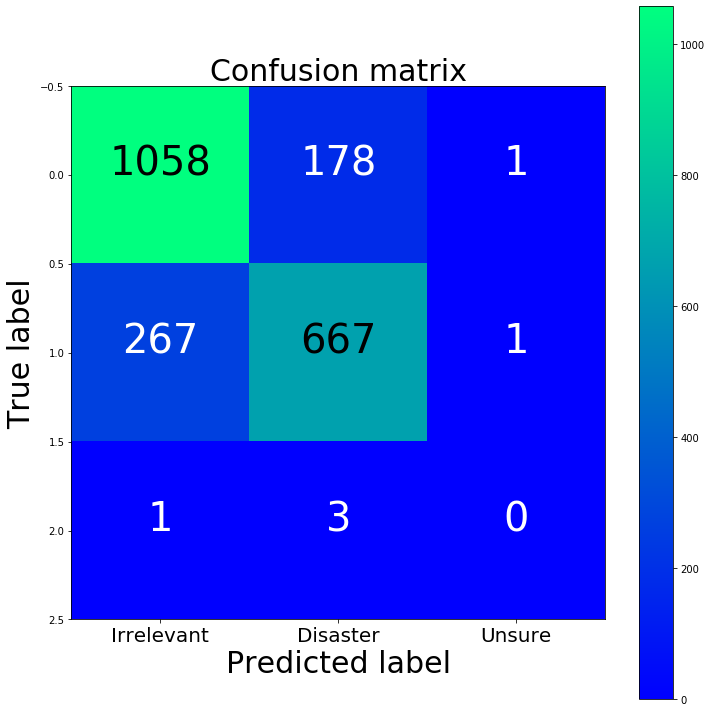

In [30]:
cm = confusion_matrix(embedding.test.y, y_predict)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()

### KFold cross-validation
Evaluating a Machine Learning model can be quite tricky. So far, we have split the data set into training and testing sets and used the training set to train the model and testing set to test the model. We then evaluated the model performance based on an error metric to determine the accuracy of the model. This method, however, is not very reliable as the accuracy obtained for one test set can be very different to the accuracy obtained for a different test set. K-fold Cross Validation(CV) provides a solution to this problem by dividing the data into folds and ensuring that each fold is used as a testing set at some point. 

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# We use a pipeline to ensure that the vectorizer fit and transform 
# happens separately for each fold
clf = make_pipeline(TfidfVectorizer(), lsvm_classifier())
data_X = X_train
data_y = y_train

# Use full dataset
scores = cross_validate(clf, data_X, data_y, scoring=['accuracy'], cv=5, return_train_score=True)
print("Validation accuracy - Mean:{:2.2%}, Std:{:2.2%}".format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()))

Validation accuracy - Mean:78.87%, Std:1.04%


### Grid Search CV
Classifiers often have various parameters (often called hyper-parameters) which can affect the accuracy of the model. You can combine cross-validation with a hyper-parameter search to find the optimal set of parameters

In [32]:
from sklearn.model_selection import GridSearchCV

# for each parameter specify a range of values you want to test
C_range    = 2. ** np.arange(-5, 5, step=1)

# build a dictionary of parameters
parameters = [{'logisticregression__C': C_range}]

# pass the dictionary to GridSearchCV specifying that it's the LogisticRegression
# and indicating the number of cross validation folds
clf = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500))
grid = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# display the results
bestC = grid.best_params_['logisticregression__C']
print (f"The best parameters are: cost = {bestC}")

The best parameters are: cost = 1.0


In [33]:
# use the best parameters and check the accuracy metrics
clf = LogisticRegression(C=1.0, solver='lbfgs', multi_class='auto', max_iter=500)
clf.fit(*tfidf.train)
accuracy, precision, recall, f1 = get_metrics(tfidf.test.y, clf.predict(tfidf.test.X))
print("accuracy = {:2.2%}, precision = {:2.2%}, recall = {:2.2%}, f1 = {:2.2%}".format(accuracy, precision, recall, f1))

accuracy = 80.65%, precision = 80.69%, recall = 80.65%, f1 = 80.31%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Try using grid search for the SVM classifier

### Training, Validation and Test datasets

Generally, best practice is to have Training, Validation (sometimes called Dev) and Test Datasets.

- Training set: A set of examples used for learning, that is to fit the parameters of the classifier.
- Validation set: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.
- Test set: A set of examples used only to assess the performance of a fully-specified classifier.

For a more detailed discussion, see: https://machinelearningmastery.com/difference-test-validation-datasets/